## [II. Initialisation et Chargement des données](#sommaire) <a name='initialisation'></a>

#### 1. Import library  <a name='import'></a>

In [2]:
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Libraries des algorithmes de classification
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


#Afin de pouvoir afficher toutes les colonnes et les linges,
# nous supprimer la restriction sur le nombre maximal de colonne à afficher.

pd.set_option('display.max_columns',None)
pd.set_option('display.max_row',None)

#### 2. Chargement de Dataset <a name='dataset'></a>

Dans cette section, nous allons charger nos données et effectuer certains traitements sur nos colonnes

In [3]:
# Chargement du fichier csv dans un dataframe
dataset = pd.read_csv('dataset/pop_failures.csv',sep=';')
dataset.head()

,Study Run,vconst_corr,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,slm_corr,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome,Unnamed: 20
0,1,1,0.859036,0.927825,0.252866,0.298838,0.170521,0.735936,0.428325,0.567947,0.474370,0.245675,0.104226,0.869091,0.997518,0.448620,0.307522,0.858310,0.796997,0.869893,0
1,1,2,0.606041,0.457728,0.359448,0.306957,0.843331,0.934851,0.444572,0.828015,0.296618,0.616870,0.975786,0.914344,0.845247,0.864152,0.346713,0.356573,0.438447,0.512256,1
2,1,3,0.997600,0.373238,0.517399,0.504993,0.618903,0.605571,0.746225,0.195928,0.815667,0.679355,0.803413,0.643995,0.718441,0.924775,0.315371,0.250642,0.285636,0.365858,1
3,1,4,0.783408,0.104055,0.197533,0.421837,0.742056,0.490828,0.005525,0.392123,0.010015,0.471463,0.597879,0.761659,0.362751,0.912819,0.977971,0.845921,0.699431,0.475987,1
4,1,5,0.406250,0.513199,0.061812,0.635837,0.844798,0.441502,0.191926,0.487546,0.358534,0.551543,0.743877,0.312349,0.650223,0.522261,0.043545,0.376660,0.280098,0.132283,1


## [III. Exploration des données](#sommaire) <a name='exploration'></a>

#### 1. Création d'index <a name='index'></a>
Nous allons créer un index à partir des deux premières colonnes de nos données et supprimer celles-ci pour ne reténir que les varibales qui nous seront utiles pour la suite de notre étude.<br>
Nous profiterons pour renommer la variable **Unnamed: 20**. Nous l'appelerons en **class**

In [4]:
dataset['id_simul'] = dataset['Study Run'].astype(str)+dataset['vconst_corr'].astype(str)
dataset.index = dataset['id_simul']
dataset = dataset[['vconst_2','vconst_3','vconst_4','vconst_5','vconst_7','ah_corr','ah_bolus', 'slm_corr','efficiency_factor', 'tidal_mix_max', 'vertical_decay_scale','convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_ban', 'bckgrnd_vdc_eq','bckgrnd_vdc_psim', 'Prandtl', 'outcome', 'Unnamed: 20']]

#On renomme la variable 'Unnamed: 20' en Unnamed_20
dataset = dataset.rename(columns={'Unnamed: 20':'class'})

dataset.head()

,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,slm_corr,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome,class
id_simul,,,,,,,,,,,,,,,,,,,
11,0.859036,0.927825,0.252866,0.298838,0.170521,0.735936,0.428325,0.567947,0.474370,0.245675,0.104226,0.869091,0.997518,0.448620,0.307522,0.858310,0.796997,0.869893,0
12,0.606041,0.457728,0.359448,0.306957,0.843331,0.934851,0.444572,0.828015,0.296618,0.616870,0.975786,0.914344,0.845247,0.864152,0.346713,0.356573,0.438447,0.512256,1
13,0.997600,0.373238,0.517399,0.504993,0.618903,0.605571,0.746225,0.195928,0.815667,0.679355,0.803413,0.643995,0.718441,0.924775,0.315371,0.250642,0.285636,0.365858,1
14,0.783408,0.104055,0.197533,0.421837,0.742056,0.490828,0.005525,0.392123,0.010015,0.471463,0.597879,0.761659,0.362751,0.912819,0.977971,0.845921,0.699431,0.475987,1
15,0.406250,0.513199,0.061812,0.635837,0.844798,0.441502,0.191926,0.487546,0.358534,0.551543,0.743877,0.312349,0.650223,0.522261,0.043545,0.376660,0.280098,0.132283,1


#### 2. Données manquantes <a name='missing_value'></a>

In [5]:
dataset.isnull().sum()

vconst_2                0
vconst_3                0
vconst_4                0
vconst_5                0
vconst_7                0
ah_corr                 0
ah_bolus                0
slm_corr                0
efficiency_factor       0
tidal_mix_max           0
vertical_decay_scale    0
convect_corr            0
bckgrnd_vdc1            0
bckgrnd_vdc_ban         0
bckgrnd_vdc_eq          0
bckgrnd_vdc_psim        0
Prandtl                 0
outcome                 0
class                   0
dtype: int64

Nous observons ici qu'il n'y a pas de données manquantes dans nos différentes variables. Nous pouvons à présent analyser la distribution des valeurs de nos variables.

#### 3. Analyse de la  distribution des variables <a name='describe'></a>
<br>
Analysons à présent la distribution de nos différentes variables en affichant les paramètres statistiques

In [6]:
dataset.describe()

,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,slm_corr,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome,class
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,0.500026,0.500097,0.500027,0.500119,0.500001,0.499913,0.500059,0.500076,0.500044,0.500111,0.499984,0.500032,0.499933,0.499944,0.499946,0.500044,0.500020,0.500021,0.914815
std,0.288939,0.288922,0.289067,0.288993,0.288827,0.288852,0.289010,0.288909,0.288860,0.288966,0.289127,0.289014,0.288822,0.288949,0.288923,0.288813,0.288936,0.289013,0.279416
min,0.000414,0.001922,0.001181,0.001972,0.000858,0.000476,0.004590,0.000296,0.003231,0.002015,0.000419,0.001188,0.001312,0.002509,0.000732,0.000891,0.000219,0.000263,0.000000
25%,0.249650,0.251597,0.251540,0.250158,0.250630,0.251325,0.253048,0.250402,0.252661,0.250758,0.251676,0.249669,0.249988,0.249586,0.249974,0.250412,0.252739,0.249723,1.000000
50%,0.499998,0.499595,0.500104,0.500456,0.500903,0.499174,0.499070,0.500074,0.500295,0.500393,0.500322,0.500151,0.500625,0.499080,0.499959,0.500384,0.498955,0.499431,1.000000
75%,0.750042,0.750011,0.749180,0.750348,0.748988,0.748166,0.750109,0.749091,0.748605,0.749447,0.749346,0.749164,0.749569,0.750012,0.747978,0.749256,0.748539,0.749792,1.000000
max,0.999194,0.998815,0.998263,0.997673,0.998944,0.997142,0.998930,0.998506,0.997172,0.999536,0.999942,0.997718,0.997518,0.999795,0.999155,0.997265,0.999306,0.999655,1.000000


L'analyse des paramètres statistiques montre que nos variables sont normalisées. Ces valeurs sont toutes comprises entre 0 et 1. De plus, on ne remarque pas de véritables écart dans la distribution des valeurs.<br>
Au régard de ces paramètres, on pourrait ainsi considérer que la recherche de valeurs abérante n'est donc pas nécéssaire. Cependant nous analyserons un peu plus en détail ces distributions dans les section suivantes pour nous en assuré.

#### 4. Etude de corrélation <a name='correlation'></a>

Nous nous servirons de la matrice de correlation pour construire un heatmap afin d'identifier les relations linéaires qui pourraient exister entre nos différentes variables. <br>
Ci-dessous la matrice de corrélation entre les variables 

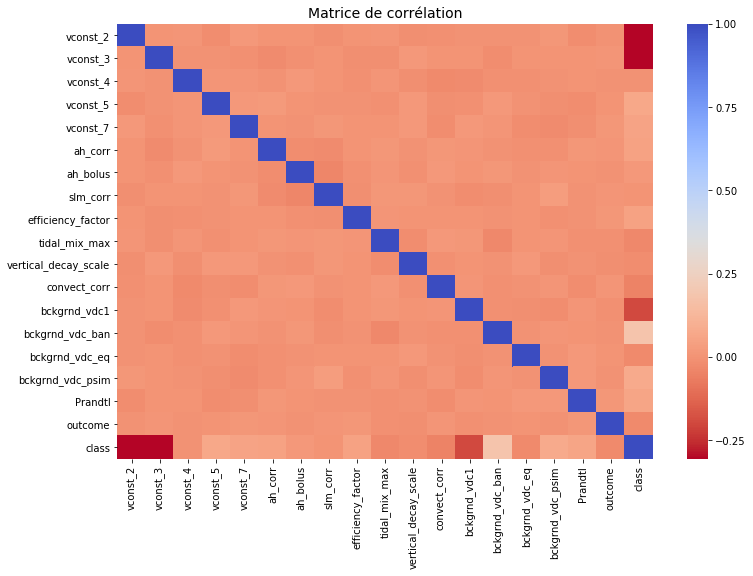

In [8]:
f, (ax1) = plt.subplots(1, 1, figsize=(12,8))

corr = dataset.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Matrice de corrélation", fontsize=14)


plt.show()

L'observation du heatmap montre qu'il existe bien une corrélation entre certaines de nos variables.
Nous analyserons en détail les corrélations entre nos différentes variables d'entrées et la variable **class** qui représente le résulats de la simulation. 
<br> Ainsi, nous pouvons observer que la variable **class** est négativement correlée aux variables **vconst_2, vconst_3, bckgrnd_vdc1** et positivement correlée à la variable **bckgrnd_vdc_ban**. <br>
Ces résultats nous permettent de dire que: 
* Plus les valeurs de variables **vconst_2, vconst_3, bckgrnd_vdc1** seront faibles, plus la simulation aura la chance d'aboutir à un succès. Et plus ces valeurs seront élevées plus la simulation aura la chance d'aboutir à un échec.
* Plus la valeur du **bckgrnd_vdc_ban** sera élevée, plus la simulation aboutira à un succès et plus la valeur sera faible plus la simulation aura la chance d'aboutir à un échec. <br>

Essayons de mieux comprendre à travers des graphes à l'aide des boxplots.

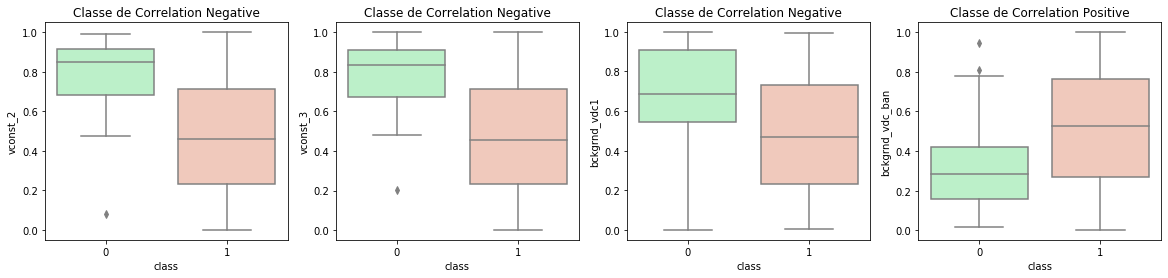

In [9]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ['#B3F9C5', '#f9c5b3']
# Corrélative négative avec nos classes de prédiction (Plus la valeurs de chacune des variables sera faible, plus la simulation aboutira à un succès)
sns.boxplot(x="class", y="vconst_2", data=dataset, palette=colors, ax=axes[0])
axes[0].set_title('Classe de Correlation Negative')

sns.boxplot(x="class", y="vconst_3", data=dataset, palette=colors, ax=axes[1])
axes[1].set_title('Classe de Correlation Negative')


sns.boxplot(x="class", y="bckgrnd_vdc1", data=dataset, palette=colors, ax=axes[2])
axes[2].set_title('Classe de Correlation Negative')


sns.boxplot(x="class", y="bckgrnd_vdc_ban", data=dataset, palette=colors)
axes[3].set_title('Classe de Correlation Positive')




plt.show()

La visualisation des différents boxplot conforte bien notre analyse sur la corélation entre nos variabes.

#### 5. Gestion des valeurs abbérantes <a name='outlier'></a>
Comme nous l'avions mentionné plus haut, l'observations des paramètres statistiques laissait croire qu'il n'y avait pas de valeurs abérantes dans nos distribution. Cependant, les boxplot affichés ci-dessus montre quelques points se trouvant en dehors des intervalles interquatile au niveau des simulations ayant échouées. 
<br>Notre objectif dans cette section sera de vérifier si les valeurs en déhors des intervalles interquartiles observées sur nos boxplots constituent des valeurs abbérentes et le cas échéant, de les supprimer. <br>

Commençons par visualiser la distribution de nos quatre variables fortement corrélées avec nos classe de prédiction.


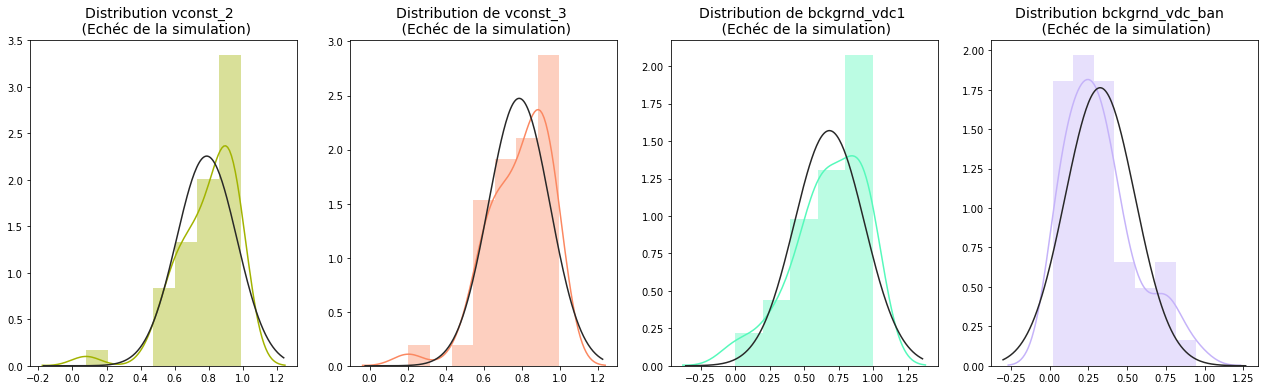

In [11]:
f, (ax1, ax2, ax3,ax4) = plt.subplots(1,4, figsize=(22, 6))

vconst_2_dist = dataset['vconst_2'].loc[dataset['class'] == 0].values
sns.distplot(vconst_2_dist,ax=ax1, fit=norm, color='#A2B300')
ax1.set_title('Distribution vconst_2  \n (Echéc de la simulation)', fontsize=14)

vconst_3_dist = dataset['vconst_3'].loc[dataset['class'] == 0].values
sns.distplot(vconst_3_dist,ax=ax2, fit=norm, color='#FB8861')
ax2.set_title('Distribution de vconst_3 \n (Echéc de la simulation)', fontsize=14)

bckgrnd_vdc1_dist = dataset['bckgrnd_vdc1'].loc[dataset['class'] == 0].values
sns.distplot(bckgrnd_vdc1_dist,ax=ax3, fit=norm, color='#56F9BB')
ax3.set_title('Distribution de bckgrnd_vdc1 \n (Echéc de la simulation)', fontsize=14)

bckgrnd_vdc_ban_dist = dataset['bckgrnd_vdc_ban'].loc[dataset['class'] == 0].values
sns.distplot(bckgrnd_vdc_ban_dist,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('Distribution bckgrnd_vdc_ban  \n (Echéc de la simulation)', fontsize=14)

plt.show()

Une stratégie possible pour ôter des points aberrants est de considérer comme valeurs abérantes toutes valeurs en dehors de l'intervalle défini par: <br>
   * **[premier quartile−𝑝∗distance interquartile,troisième quartile+𝑝∗distance interquartile]**

Les graphiques ci-dessus montre qu'aucune de ces quatre variables ne suit une distribution Gaussiènne.
Le choix du p se fait donc abitrairement. Ainsi, nous choisierons un **p=1.5**

In [12]:
def findOutlier(p,feature):
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    
    # On affiche les valeurs quartiles
    #print('Quartile 25: {} \nQuartile 75: {} \n'.format(q25, q75))
    iqr = q75 - q25
    #print('IQR: [-{} ; +{}] \n'.format(iqr,iqr))
    
    # Seuil des valeurs extremes
    seuil = iqr * p
    inf, sup = q25 - seuil, q75 + seuil
    #print('Seuil de tolérence: {} \n'.format(seuil))
    #print('IC: [{} ; {}] \n'.format(inf,sup))
    outliers = [x for x in feature if x < inf or x > sup]
    return outliers



In [13]:
p = 3
# Récupérons les valeurs de simulation échouées de la variable vconst_2
vconst_2_echec = dataset['vconst_2'].loc[dataset['class'] == 0].values
vconst_2_outlier = findOutlier(p,vconst_2_echec)
print('Liste des valeurs abbérantes sur vconst_2: {}'.format(vconst_2_outlier))

# Récupérons les valeurs de simulation échouées de la variable vconst_3
vconst_3_echec = dataset['vconst_3'].loc[dataset['class'] == 0].values
vconst_3_outlier = findOutlier(p,vconst_3_echec)
print('Liste des valeurs abbérantes sur vconst_3: {}'.format(vconst_3_outlier))

# Récupérons les valeurs de simulation échouées de la variable bckgrnd_vdc1
bckgrnd_vdc1_echec = dataset['vconst_3'].loc[dataset['class'] == 0].values
bckgrnd_vdc1_outlier = findOutlier(p,bckgrnd_vdc1_echec)
print('Liste des valeurs abbérantes sur bckgrnd_vdc1: {}'.format(bckgrnd_vdc1_outlier))

# Récupérons les valeurs de simulation échouées de la variable bckgrnd_vdc_ban
bckgrnd_vdc_ban_echec = dataset['bckgrnd_vdc_ban'].loc[dataset['class'] == 0].values
bckgrnd_vdc_ban_outlier = findOutlier(p,bckgrnd_vdc_ban_echec)
print('Liste des valeurs abbérantes sur bckgrnd_vdc_ban: {}'.format(bckgrnd_vdc_ban_outlier))

Liste des valeurs abbérantes sur vconst_2: []
Liste des valeurs abbérantes sur vconst_3: []
Liste des valeurs abbérantes sur bckgrnd_vdc1: []
Liste des valeurs abbérantes sur bckgrnd_vdc_ban: []


L'analyse que nous venons d'effectuer n'a trouvé aucune valeur abbérente nous pouvons maintenant passer à une autre étape de l'étude.

#### 6. Exploration univariée <br> <a name='univariable'></a>
Maintenant que nous nous assuré d'avoir  des données saines, regardons de près la distribution de nos classes de prédiction à travers la variable **class** 

Le nombre de simulation ayant échoué est de 46 sur 540 avec soit: 8.52%
Le nombre de simulation ayant succès est de 494 sur 540 avec soit: 91.48%


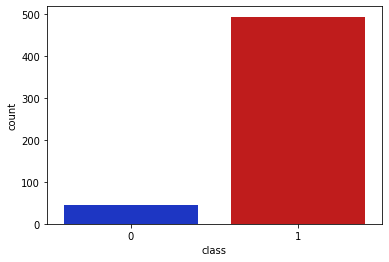

In [15]:
echec = dataset['class'].value_counts()[0]
succes = dataset['class'].value_counts()[1]

# Affichage de la répartitions des classes
print('Le nombre de simulation ayant échoué est de {} sur {} avec soit: {}%'.format(echec,len(dataset), round(echec/len(dataset) * 100,2), '% of the dataset'))
print('Le nombre de simulation ayant succès est de {} sur {} avec soit: {}%'.format(succes,len(dataset), round(succes/len(dataset) * 100,2), '% of the dataset'))

# Répsentons graphiquement la répartiton de nos classes
colors = ["#0123DF", "#DA0101"]
sns.countplot('class', data=dataset,palette=colors)

Après analyse de la variable **class**, nous constatons un déséquilibre dans la répartition des résultats de simulations: il y a beaucoup trop de cas de **succès** que d'**échec**. <br>Envion **91% de simulations reussies** contre seulement seulement **8% de simulations échouées**.  Ceci pose un problème car si nous appliquons nos algorithme d'apprentissage sur ces données nous pourions être confrontés au phénomène d'**overfitting**. La performance des nos modèles déprendra fortement de nos données.<br>
Nous créérons tout de même dans les sections suivantes des modèles d'apprentissage à partir de ces données déséquilibrées dans un premier temps avant d'utiliser une technique de reéchantillonnage pour réequilibrer la répartition des classes de prédiction et réaliser de nouveaux modèle d'apprentissage sur les données équilibrées.

## [IV. Algorithmes d'apprentissage](#sommaire) <a name='algorithmes'></a>

Dans cette section, nous entrainerons nos modèles sur les huit algorithmes de classification suivants:

* Logisitic Regression
* GaussianNB
* GradientBoostingClassifier
* KNearest
* Support Vector Classifier
* Random Forest
* Decision Tree Classifier
* Extra Trees Classifier

Dans un premier temps nous utiliserons ces algorithmes de façon générique et analyserons la performance de chacune d'elle. Après celà, nous nous servirons de l'outil GridSearchCV disponible dans la librairie sklearn pour déterminer les meilleurs paramètres de nos différents modèles et effectuerons par la suite une validation croisée avec les données de tests pour analyser de nouveau la performance des différents classifiers.

#### 1. Création du modèle d'apprentissage <a name='models'></a>

Nous allons spliter nos données en deux groupe de données les données d'entainement et les données de tests. Nous utiliserons dans un premier temps les données d'entrainement pour effecuter l'apprentissage de nos différents classiffiers. Les données de test nous servirons plutard à vérifier la précision de nos algorithmes sur données n'ayant pas servis à l'apprentissage.

In [16]:
# Séléction des variables indépendantes et dépendantes
X = dataset.drop('class', axis=1)
y = dataset['class']

# Création des données d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Transformons les valeurs en un tableau 
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values


#### 2. Initialisation des classifiers <a name='learning'></a>

In [17]:
# Création des classifiers
# On definit un dictionnaire de nos différents alogorithmes afin d'appliquer un cross validation sur chacun
classifiers = {
    "Gaussian NB":GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logisitic Regression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Extra Trees":ExtraTreesClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Decision Trees": DecisionTreeClassifier()
}



#### 3. Validation croisées <a name='validation'></a>

In [18]:
kfold = StratifiedKFold(n_splits=4)
list_classifiers_mean = []
list_classifiers_std = []
save_classifiers = []
for key, classifier in classifiers.items():

    model = classifier.fit(X_train, y_train)
    #print(model)
    training_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring = "accuracy", n_jobs=2)
    save_classifiers.append(classifier)
    list_classifiers_mean.append(round(training_score.mean()* 100, 2))
    list_classifiers_std.append(round(training_score.std()* 100, 2))
    
    

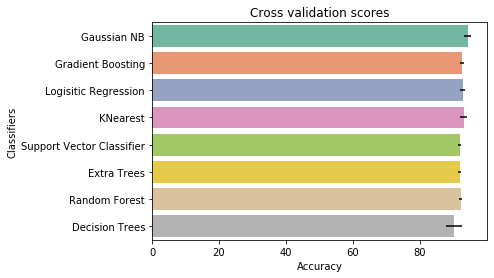

In [19]:
# afficher les résultats des scores des 8 algorithmes
list_classifier = list(classifiers.keys())
cv_res = pd.DataFrame({
                       "Classifiers":list_classifier,
                        "Means":list_classifiers_mean,
                        "Standard_Error": list_classifiers_std})

barplot = sns.barplot("Means",
                      "Classifiers",
                      data = cv_res,
                      palette="Set2",
                      orient = "h",**{'xerr':list_classifiers_std})
barplot.set_xlabel("Accuracy")
barplot = barplot.set_title("Cross validation scores")




In [20]:
cv_res.sort_values(by=['Means'],ascending=False)

,Classifiers,Means,Standard_Error
0,Gaussian NB,94.21,1.01
3,KNearest,93.06,1.04
2,Logisitic Regression,92.82,0.77
1,Gradient Boosting,92.59,0.65
6,Random Forest,92.13,0.46
4,Support Vector Classifier,91.90,0.40
5,Extra Trees,91.90,0.40
7,Decision Trees,90.05,2.39


La métrique accuracy donne pour résultats les meilleurs classifiers suivants: Gaussian NB, KNearest, Random Forest , Gradient Boosting et Logisitic Regression. Essayons maintenant de booster ces classifiers en recherchant les paramètres optimaux afin d'analyser une fois fois de plus leur performance. Nous booster seulement les 5 meilleurs que nous venons de lister mais étant donnée que les scores des autres classifiers ne sont pas très faibles, n ous allons appliquer notre recherce à tous nous classifiers.

#### 4. Recherche des paramètres optimaux <a name='gridSh'></a>

Nous utiliserons dans cette sections le GridSearchCV pour détecter les paramètres optimaux des différents classifiers. 

In [22]:
# listons les paramètres de nos classifiers

#Parametres du classfier logistic Regression


log_reg_params = {"penalty": ['l2','l1'],
                  "C":np.logspace(0,4,10),
                  "solver":['liblinear']
                 }


#Parametres du classfier gradient Boosting
grad_boost_params = {
    "loss":["deviance"],
    "learning_rate": [0.1, 0.2, 0.5],
    "max_depth":[None],
    "criterion": ["friedman_mse","mae","mse"],
    "n_estimators" :[100,300],
    }


#Parametres du classfier Gaussian Naive Bayes
gauss_params = {
    "priors":[None,[0.1, 0.9]],
    "var_smoothing":[1e-09, 1e-06, 1e-03]
              }

#Parametres du classfier KNN
knears_params = {
    "n_neighbors": [4,5,6],
    "algorithm": ['auto','ball_tree','kd_tree','brute'],
    "p":[3,4,5],
    "weights":['uniform', 'distance'],
}

#Parametres du classfier Support Vector
svc_params = {
    "C": np.logspace(0,4,10),
    "kernel": ['rbf','poly','sigmoid','linear'],
    "probability":[True,False],
    "degree":[3,4,5],
    "shrinking":[False,True]
}

#Parametres du classfier Extra Trees
extra_tree_params = {
    "n_estimators" :[100,300],
    "criterion": ["gini"],
    "max_depth": list(range(2,10,1)),
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "max_features":["auto", "sqrt", "log2"]
    }


#Parametres du classfier Decision Trees
tree_params = {"max_depth": [None],
              "max_features": [None],
              "min_samples_split": list(range(2,5,1)),
              "min_samples_leaf": [1, 3, 10],
              "criterion": ["gini","entropy"]}


#Parametres du classfier random Forrest
rfc_params = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini", "entropy"]}

list_param_classifiers = [gauss_params,grad_boost_params,log_reg_params,
                          knears_params,svc_params,extra_tree_params,
                          rfc_params,tree_params]



In [24]:
i = 0
list_classifiers_mean_bestParam = []
list_classifiers_std_bestParam = []
save_best_param = []
for key,classifier in classifiers.items():
    grid = GridSearchCV(classifier,param_grid = list_param_classifiers[i])
    best_estimator =  grid.fit(X_train, y_train).best_estimator_
    score = cross_val_score(best_estimator, X_train, y_train, cv=kfold, scoring = "accuracy", n_jobs=2)
    save_best_param.append(best_estimator)
    list_classifiers_mean_bestParam.append(round(score.mean()* 100, 2))
    list_classifiers_std_bestParam.append(round(score.std()* 100, 2))
    i += 1

###### Comparaison des classifiers après Tunning des hyperparamètres

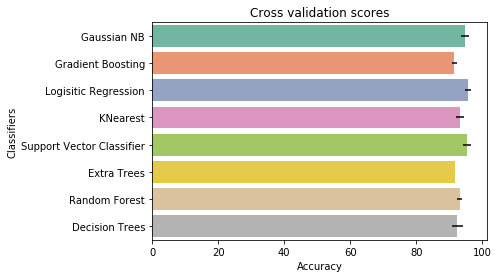

In [25]:
# afficher les résultats des scores des 8 algorithmes
list_classifier = list(classifiers.keys())
cv_res = pd.DataFrame({
                       "Classifiers":list_classifier,
                        "Means":list_classifiers_mean_bestParam,
                        "Standard_Error": list_classifiers_std_bestParam})
barplot = sns.barplot("Means",
                      "Classifiers",
                      data = cv_res,
                      palette="Set2",
                      orient = "h",**{'xerr':list_classifiers_std_bestParam})
barplot.set_xlabel("Accuracy")
barplot = barplot.set_title("Cross validation scores")




In [26]:
cv_res.sort_values(by=['Means'],ascending=False)

,Classifiers,Means,Standard_Error
2,Logisitic Regression,95.60,0.77
4,Support Vector Classifier,95.37,1.13
0,Gaussian NB,94.68,1.20
3,KNearest,93.29,1.20
6,Random Forest,93.06,0.80
7,Decision Trees,92.36,1.65
5,Extra Trees,91.67,0.00
1,Gradient Boosting,91.44,0.77


#### 6. Learning Curve des classifiers <a name='learning_Curve'></a>

In [28]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4,
                        estimator5, estimator6, estimator7, estimator8,
                        X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    f, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20,14), sharey=True)
   
    if ylim is not None:
        plt.ylim(*ylim)
    
    # Logistic Regression
    train_sizes, train_scores, test_scores = learning_curve(
    estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="#2492ff")
    ax1.plot(train_sizes,
             train_scores_mean, 'o-',
             color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes,
             test_scores_mean, 'o-', 
             color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Regression Logistic",
                  fontsize=14)
    ax1.set_xlabel('Training size')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    
    # Support Vector Classifier
    train_sizes, train_scores, test_scores = learning_curve(
    estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax5.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1,
                     color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-',
             color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes,
             test_scores_mean, 
             'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Support Vector Classifier",
                  fontsize=14)
    ax2.set_xlabel('Training size\n\n')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
        
     # Gaussian Naive Bayes 
    train_sizes, train_scores, test_scores = learning_curve(
    estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="#2492ff")
    ax3.plot(train_sizes,
             train_scores_mean, 'o-',
             color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, 
             test_scores_mean, 'o-',
             color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("\n Gaussian Naive Bayes",
                  fontsize=14)
    ax3.set_xlabel('Training size\n')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
        
    
    
     
    # Knears Neighbors
    train_sizes, train_scores, test_scores = learning_curve(
    estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="#2492ff")
    ax4.plot(train_sizes,
             train_scores_mean, 'o-', 
             color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-',
             color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Knears Neighbors ", fontsize=14)
    ax4.set_xlabel('Training size\n\n')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    
    
    
    # Random Forest Classifier
    train_sizes, train_scores, test_scores = learning_curve(
    estimator5, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax5.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="#ff9124")
    ax5.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="#2492ff")
    ax5.plot(train_sizes,
             train_scores_mean, 'o-',
             color="#ff9124",
             label="Training score")
    ax5.plot(train_sizes,
             test_scores_mean, 'o-', 
             color="#2492ff",
             label="Cross-validation score")
    ax5.set_title("Random Forest Classifier",
                  fontsize=14)
    ax5.set_xlabel('Training size')
    ax5.set_ylabel('Score')
    ax5.grid(True)
    ax5.legend(loc="best")
    
    
    
    # Decision Tree Classifier 
    train_sizes, train_scores, test_scores = learning_curve(
    estimator6, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax6.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="#ff9124")
    ax6.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="#2492ff")
    ax6.plot(train_sizes, 
             train_scores_mean, 'o-',
             color="#ff9124",
             label="Training score")
    ax6.plot(train_sizes,
             test_scores_mean, 'o-',
             color="#2492ff",
             label="Cross-validation score")
    ax6.set_title("Decision Tree Classifier",
                  fontsize=14)
    ax6.set_xlabel('Training size \n\n')
    ax6.set_ylabel('Score')
    ax6.grid(True)
    ax6.legend(loc="best")
    
    # Extra Trees Classifier 
    train_sizes, train_scores, test_scores = learning_curve(
    estimator7, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax7.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="#ff9124")
    ax7.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1,
                     color="#2492ff")
    ax7.plot(train_sizes, train_scores_mean,
             'o-', color="#ff9124",
             label="Training score")
    ax7.plot(train_sizes,
             test_scores_mean, 'o-', 
             color="#2492ff",
             label="Cross-validation score")
    ax7.set_title("Extra Trees Classifier", fontsize=14)
    ax7.set_xlabel('Training size')
    ax7.set_ylabel('Score')
    ax7.grid(True)
    ax7.legend(loc="best")
    
    # Gradient Boosting Classifier 
    train_sizes, train_scores, test_scores = learning_curve(
    estimator8, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax8.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="#ff9124")
    ax8.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="#2492ff")
    ax8.plot(train_sizes,
             train_scores_mean, 'o-',
             color="#ff9124",
             label="Training score")
    ax8.plot(train_sizes, test_scores_mean, 'o-',
             color="#2492ff",
             label="Cross-validation score")
    ax8.set_title("Gradient Boosting Classifier",
                  fontsize=14)
    ax8.set_xlabel('Training size')
    ax8.set_ylabel('Score')
    ax8.grid(True)
    ax8.legend(loc="best")
    
    return plt

<module 'matplotlib.pyplot' from '/Users/karidioulah/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

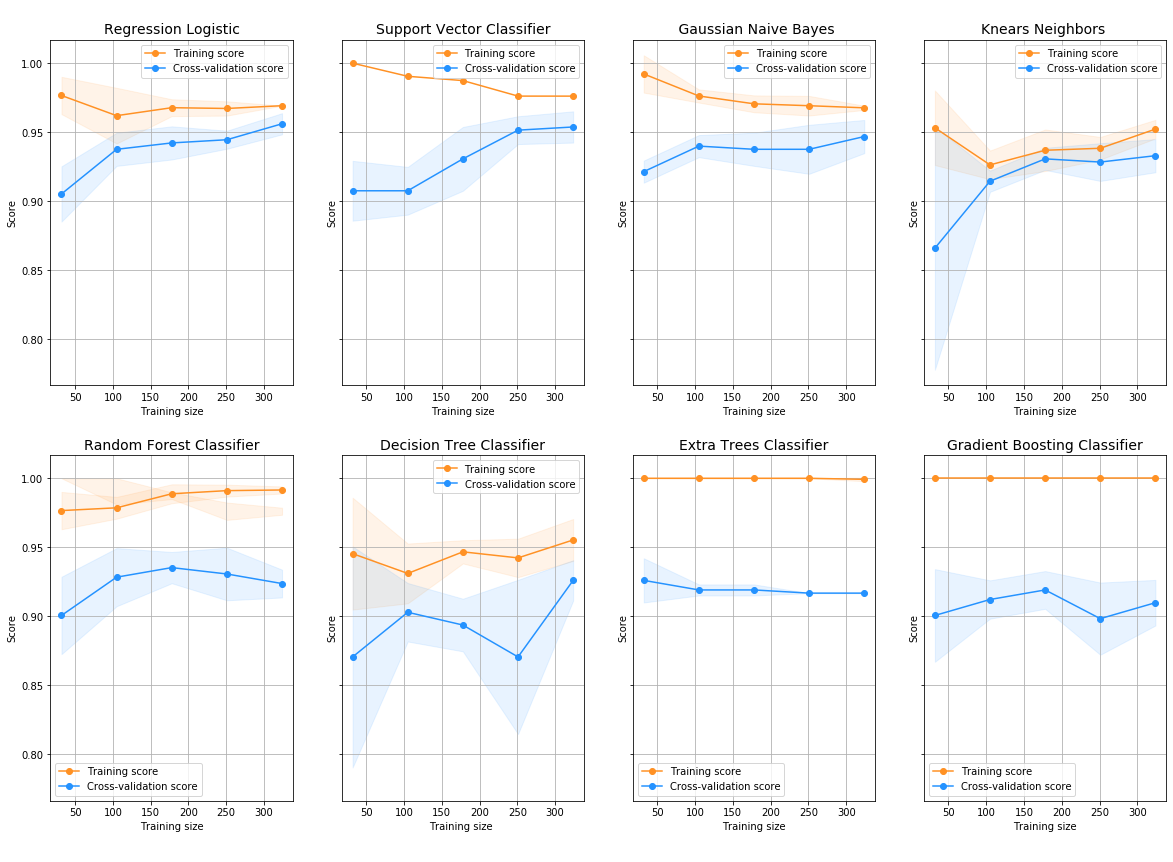

In [29]:
plot_learning_curve(save_best_param[2],save_best_param[4],
                    save_best_param[0],save_best_param[3],
                    save_best_param[6],save_best_param[7],
                    save_best_param[5],save_best_param[1],
                    X_train,y_train,cv=kfold)

Après le boosting des hyperparamètres, nous retenons les cinq classiifers ayant les meilleurs score d'accuracy. Ces classifiers sont les suivants:  **Logisitic Regression**, **Support Vector Classifier**,**Gaussian NB**, **KNearest** et **Random Forest**. <br> 
Nous remarquons qu'en essayant de booster le Gradient Boosting nous perdons en performance. Toutefois le score de l'accuracy obtenus sans boosting de ses hyperparamètres reste inférieur au 93,29 du random Forest qui est le classifier le moins performant des cinq classifiers retenu pour la suite de l'étude.



#### 7. ROC Curves (TOP 5) <a name='roc_curve'></a>

In [30]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.




log_reg_pred = cross_val_predict(save_best_param[2], X_train, y_train, cv=5,
                                 method="decision_function")
svc_pred = cross_val_predict(save_best_param[4], X_train, y_train, cv=5,
                             method="decision_function")
knears_pred = cross_val_predict(save_best_param[3], X_train, y_train, cv=5)
gauss_pred = cross_val_predict(save_best_param[0], X_train, y_train, cv=5)
rfc_pred = cross_val_predict(save_best_param[6], X_train, y_train, cv=5)



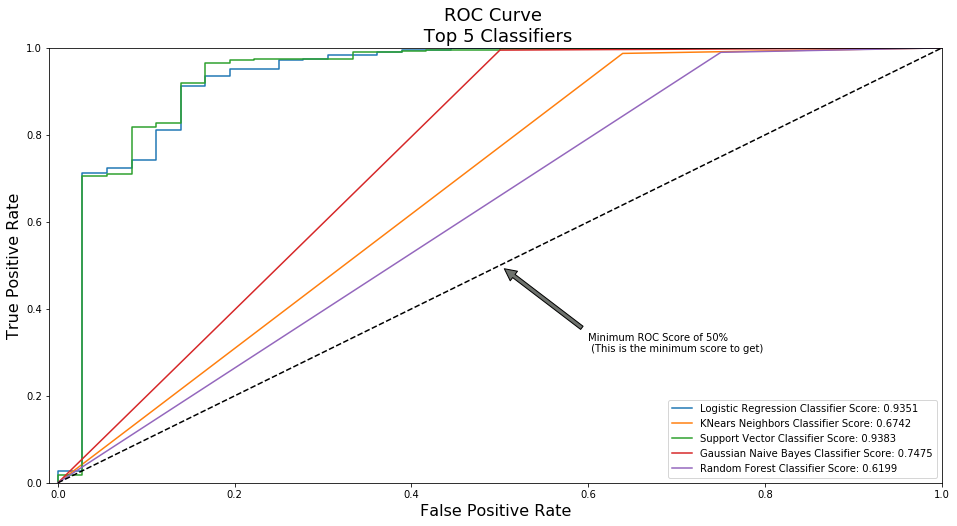

In [31]:

log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
gauss_fpr, gauss_tpr, gauss_threshold = roc_curve(y_train, gauss_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
rfc_fpr, rfc_tpr, rfc_thresold = roc_curve(y_train, rfc_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, svc_fpr, svc_tpr,knear_fpr,
                         knear_tpr,gauss_fpr, gauss_tpr,rfc_fpr, rfc_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 5 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(gauss_fpr, gauss_tpr, label='Gaussian Naive Bayes Classifier Score: {:.4f}'.format(roc_auc_score(y_train, gauss_pred)))
    plt.plot(rfc_fpr, rfc_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, rfc_pred)))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, svc_fpr, svc_tpr,knear_fpr,
                         knear_tpr,gauss_fpr, gauss_tpr,rfc_fpr, rfc_tpr)
plt.show()

Les résultat ROC Curve montre que les classifiers **Regression Logistic** et de **Support Vector** sont considerablement plus performants que les autres. Ces deux classifiers sont plus précis dans la prédiction des True Positive. 

Maintenant que nous avons nos meilleurs classifiers essayons de voir l'impact du déséquibre de la class des données sur la performance de nos classifers.

#### 8. Gestion du Imbalanced dataset <a name='imabalanced'></a>

Comme l'avons vu plus haut, il y a un déséquilibre dans la distribution de nos classes de prédiction. Ce problème qualifié de **imbalanced dataset**. Plusieurs techniques existent pour équilibrer la répartion de nos classes. <br>
Au vu de la taille réduite de nos données, nous allons utiliser une technique d'**oversampling** pour résoudre ce problème. <br> L'oversampling est une technique qui consiste à consiste à augmenter la taille de notre dataset en simulant des échantillons de la classe sous représentée de sorte qu'elle atteigne le même nombres d'enregistrements que la classe majoritaire.<br>
Nous utiliserons l'outil SMOTE de la librairie skitlearn pour reéffectuer l'enchantillonnage de nos données et élavuer encore une fois la performance de nos classifiers à l'aide d'une validation croisée.

In [34]:
sm = SMOTE(sampling_strategy='minority',random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())



print('Shape du train_X après OverSampling : {}'.format(X_train_res.shape))
print('Shape du train_y après OverSampling : {} \n'.format(y_train_res.shape))

print("Nombre de simulation succès Après OverSampling: {}".format(sum(y_train_res==1)))
print("Nombre de simulation échec Après OverSampling: {}".format(sum(y_train_res==0)))



Shape du train_X après OverSampling : (792, 18)
Shape du train_y après OverSampling : (792,) 

Nombre de simulation succès Après OverSampling: 396
Nombre de simulation échec Après OverSampling: 396


In [35]:
i = 0
mean_afterSampling_classifiers = []
std_afterSampling_classifiers = []
afterSampling_best_model = []
for key,classifier in classifiers.items():
    grid = GridSearchCV(classifier,param_grid = list_param_classifiers[i])
    best_estimator =  grid.fit(X_train_res, y_train_res).best_estimator_
    score = cross_val_score(best_estimator, X_train_res, y_train_res, cv=kfold, scoring = "accuracy", n_jobs=2)
    afterSampling_best_model.append(best_estimator)
    mean_afterSampling_classifiers.append(round(score.mean()* 100, 2))
    std_afterSampling_classifiers.append(round(score.std()* 100, 2))
    i += 1
    

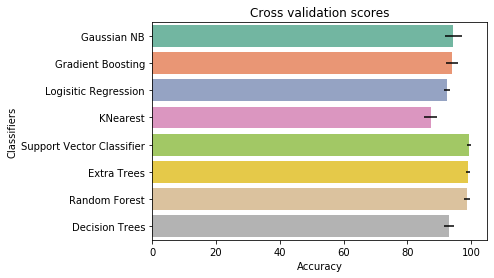

In [36]:
# afficher les résultats des scores des 8 algorithmes
#list_classifier = list(classifiers.keys())
cv_res = pd.DataFrame({
                       "Classifiers":list_classifier,
                        "Means":mean_afterSampling_classifiers,
                        "Standard_Error":std_afterSampling_classifiers})

barplot = sns.barplot("Means",
                      "Classifiers",
                      data = cv_res,
                      palette="Set2",
                      orient = "h",**{'xerr':std_afterSampling_classifiers})
barplot.set_xlabel("Accuracy")
barplot = barplot.set_title("Cross validation scores")



In [37]:
cv_res.sort_values(by=['Means'],ascending=False)

,Classifiers,Means,Standard_Error
4,Support Vector Classifier,99.37,0.55
5,Extra Trees,99.12,0.66
6,Random Forest,98.74,0.91
0,Gaussian NB,94.32,2.66
1,Gradient Boosting,94.07,1.83
7,Decision Trees,92.93,1.56
2,Logisitic Regression,92.42,0.80
3,KNearest,87.25,2.00


<module 'matplotlib.pyplot' from '/Users/karidioulah/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

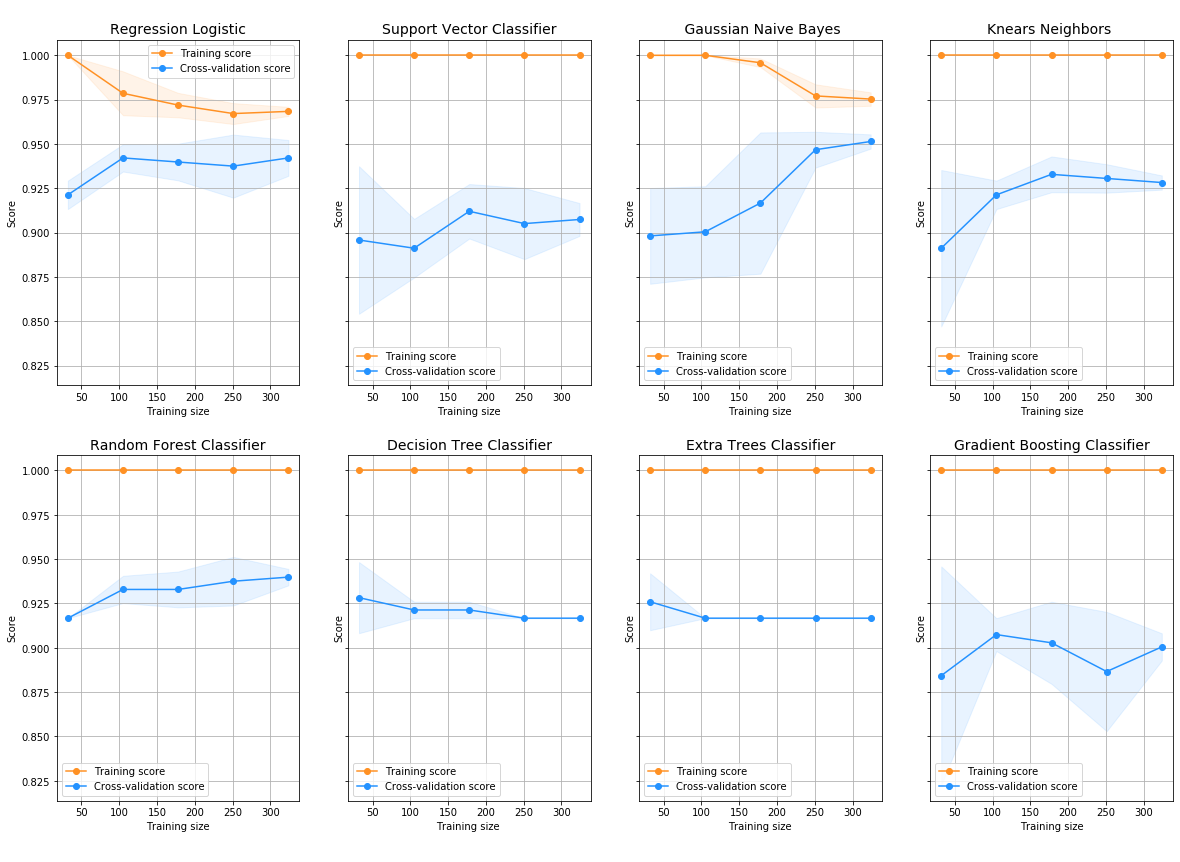

In [38]:
plot_learning_curve(afterSampling_best_model[0],afterSampling_best_model[1],
                    afterSampling_best_model[2],afterSampling_best_model[3],
                    afterSampling_best_model[4],afterSampling_best_model[5],
                    afterSampling_best_model[6],afterSampling_best_model[7],
                    X_train,y_train,cv=kfold)

La technique utilisé pour gérer le problème d'imbalanced Dataset nous renvois des modèles avec des meilleurs score d'accuracy. Mais l'allure des learning curves montre que les modèle sont fortements lié a nos données. Nous meintiendrons alors les résultats des classifiers sans le oversampling

## [V. Exploitation des Modèles](#sommaire) <a name='Model_exploitation'></a>

Dans cette section, nous exploiterons l'ensemble des utiliserons les classifiers que nous avons obtenus effectuer la prédiction sur les données que nous avons reservé pour les tests. Nous alyserons également l'apport des variables indépendantes sur les modèles obtenus.

#### 1. Features importance <a name='feature_importance'></a>

Dans cette section, nous essayerons de voir l'impacte de chacune nos variables sur nos modèles. Nous utiliserons pour cela l'outil **feature_importances** qui ne s'applique qu'à un certain nombre de classifiers (Les classifiers de type Tree) en général. Ainsi, nous l'utiliserons sur le **Random Forest** et l'**extra tree classifier** et le **Support vector Machine**.


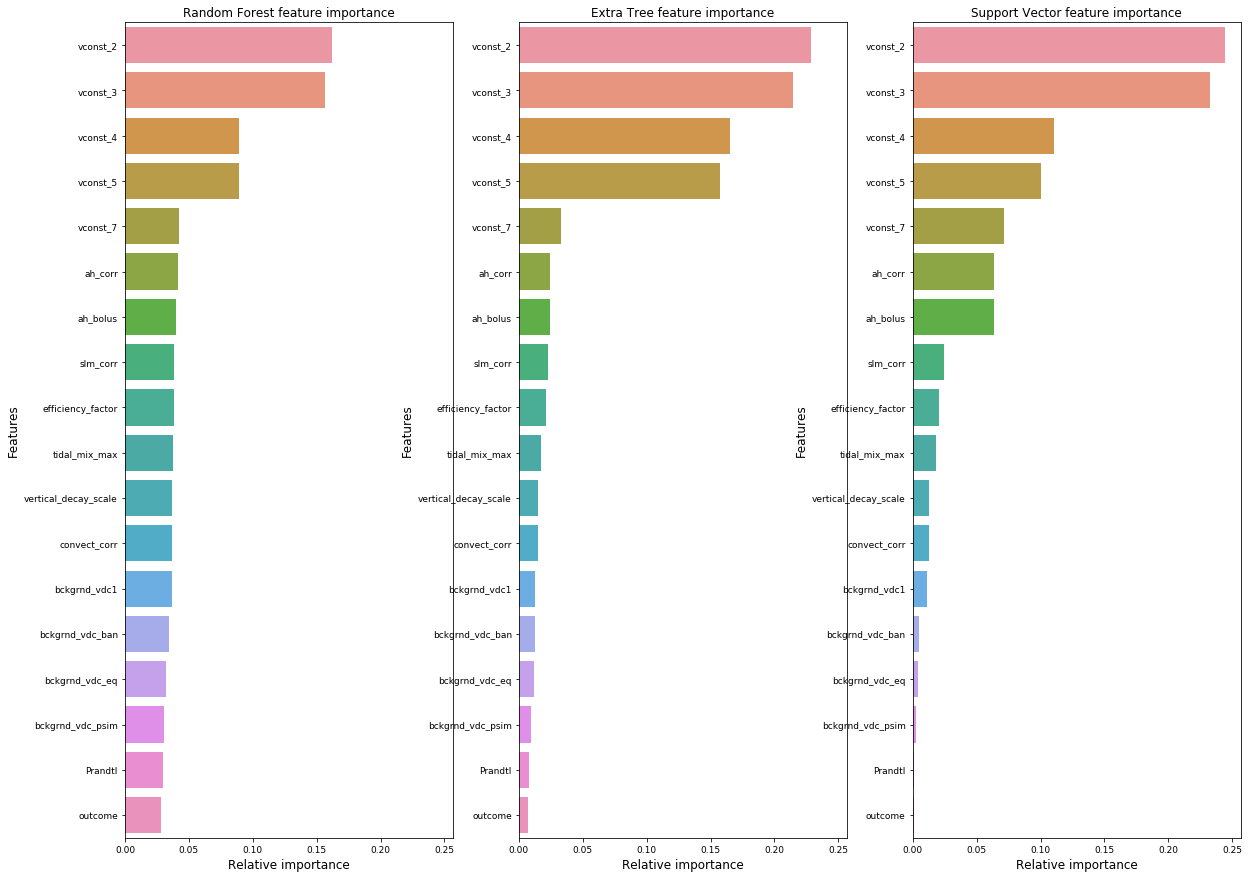

In [39]:
(nrows,ncols) = (1,3)
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(20,15))

names_classifiers = [("Random Forest",save_best_param[5]),("Extra Tree",save_best_param[6]),("Support Vector",save_best_param[1])]

nclassifier = 0

for col in range(ncols):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    
    indices = np.argsort(classifier.feature_importances_)[::-1][:18]
    
    columns_ = dataset.iloc[:1, 0:18].columns

    g = sns.barplot(y=columns_,x = classifier.feature_importances_[indices][:18] , orient='h',ax=axes[col])
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")
    nclassifier += 1

Les classifiers ci-dessus affichent l'important de nos différents features.

#### 2. Ensemble learning <a name='model_regroup'></a>

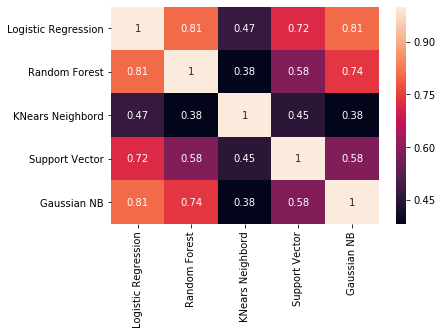

In [40]:

testRiskLogisticRegres = pd.Series(save_best_param[2].predict(X_test), name="Logistic Regression")
testRiskRandomF = pd.Series(save_best_param[6].predict(X_test), name="Random Forest")
testRiskKNN = pd.Series(save_best_param[3].predict(X_test), name="KNears Neighbord")
testRiskSVC = pd.Series(save_best_param[4].predict(X_test), name="Support Vector")
testRiskGaussianNB = pd.Series(save_best_param[0].predict(X_test), name="Gaussian NB")

ensemble_results = pd.concat([testRiskLogisticRegres,testRiskRandomF,testRiskKNN,testRiskSVC, testRiskGaussianNB],axis=1)
g= sns.heatmap(ensemble_results.corr(),annot=True)



In [41]:
print(X_train.shape)
print(y_train.shape)
X_train.astype

(432, 18)
(432,)


<function ndarray.astype>

In [42]:
vc = VotingClassifier(estimators=[("LogisticRegression",save_best_param[2]),
                                  ("RandomForest", save_best_param[6]),
                                  ("GaussianNB", save_best_param[0]),
                                  ("KNearsNeighbord",save_best_param[3]),
                                  ("SupportVector",save_best_param[4])], voting='soft', n_jobs=-1)

vc_result = vc.fit(X_train, y_train)

#### 3. Prédiction <a name='prediction'><a>

In [43]:
y_testt = pd.Series(y_test)
X_testt = pd.Series(X_test[:,0])
result_test_Risk = pd.Series(vc_result.predict(X_test), name="Value Predicted", index=X_testt.index)
reslt = pd.concat([y_testt,result_test_Risk],axis=1)

In [44]:
reslt

,0,Value Predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,0,0
6,1,1
7,1,1
8,1,1
9,1,1
